In [1]:
library(dplyr)
library(caret)
library(mice)
library(ModelMetrics)
library(randomForest)
library(forecast)
library(Rcpp) 
library(RSNNS)
library(MASS)
library(grid)
library(neuralnet)
library(FNN)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘ModelMetrics’

The following objects are masked from ‘package:caret’:

    confusionMatrix, precision, recall, sensitivity, specificity

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘RSNNS’

The following object is masked from ‘package:ModelMetrics’:

    confusionMatrix

The following objects are masked from ‘package:caret’:

    confusionMatrix, train


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘neuralnet’

The follow

In [2]:
setwd("~/Documents/INFO7390 Data Science/case study 2")
f <- read.csv("./training set/features.csv")
ts <- read.csv("./training set/loandata_2.csv")

In [3]:
# Data
co <- c(names(f),'int_rate','region')
x <- ts[,co]

In [4]:
rm(ts)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1932986,103.3,6619081,353.5,5263913,281.2
Vcells,18552786,141.6,188063760,1434.9,234813017,1791.5


# Pre

In [5]:
# Missing value
x[x == ""] <- NA
x <- x[complete.cases(x),]

In [6]:
# Pre
x[,9:12] <- data.frame(apply(x[,9:12], 2, as.factor))
# Change factor into numeric
for (i in 9:12)
    x[,i] <- as.numeric(x[,i])
x[,13:14] <- data.frame(lapply(x[,13:14], function(x) as.numeric(sub("%", "", x))/100) )

In [7]:
str(x)

'data.frame':	633305 obs. of  15 variables:
 $ annual_inc         : num  45000 44000 60000 110000 65000 50000 30000 41600 65000 80000 ...
 $ dti                : num  16.1 17.6 34.8 20.4 29.3 ...
 $ last_pymnt_amnt    : num  957 465 518 618 324 ...
 $ mths_since_rcnt_il : int  3 13 7 25 10 37 5 2 16 54 ...
 $ all_util           : int  52 91 51 54 76 44 76 75 82 21 ...
 $ total_rev_hi_lim   : int  17500 12600 20400 21700 35400 15500 23000 24700 37400 194800 ...
 $ inq_last_12m       : int  1 0 1 9 1 2 7 2 3 3 ...
 $ percent_bc_gt_75   : num  0 100 25 85.7 71.4 33.3 0 33.3 85.7 0 ...
 $ term               : num  1 2 2 2 2 1 2 1 1 1 ...
 $ grade              : num  1 5 4 5 2 2 4 2 4 1 ...
 $ sub_grade          : num  2 23 20 24 9 7 17 9 18 1 ...
 $ verification_status: num  1 3 2 1 1 1 2 1 1 1 ...
 $ revol_util         : num  0.212 1.024 0.406 0.949 0.698 ...
 $ int_rate           : num  0.0649 0.1989 0.1849 0.205 0.1078 ...
 $ region             : Factor w/ 52 levels "","AK","AL","AR",..

In [8]:
summary(x)

   annual_inc           dti         last_pymnt_amnt   mths_since_rcnt_il
 Min.   :     50   Min.   : -1.00   Min.   :    0.0   Min.   :  0.00    
 1st Qu.:  49000   1st Qu.: 12.63   1st Qu.:  268.8   1st Qu.:  7.00    
 Median :  68000   Median : 18.44   Median :  453.8   Median : 13.00    
 Mean   :  80884   Mean   : 19.12   Mean   : 2320.8   Mean   : 21.33    
 3rd Qu.:  96000   3rd Qu.: 24.94   3rd Qu.:  826.7   3rd Qu.: 24.00    
 Max.   :9573072   Max.   :999.00   Max.   :42148.5   Max.   :511.00    
                                                                        
    all_util      total_rev_hi_lim   inq_last_12m    percent_bc_gt_75
 Min.   :  0.00   Min.   :    200   Min.   : 0.000   Min.   :  0.00  
 1st Qu.: 47.00   1st Qu.:  14900   1st Qu.: 0.000   1st Qu.:  0.00  
 Median : 61.00   Median :  25600   Median : 1.000   Median : 37.50  
 Mean   : 59.87   Mean   :  34888   Mean   : 2.155   Mean   : 42.54  
 3rd Qu.: 74.00   3rd Qu.:  43300   3rd Qu.: 3.000   3rd Qu.: 71.4

# Cleaning Outliers

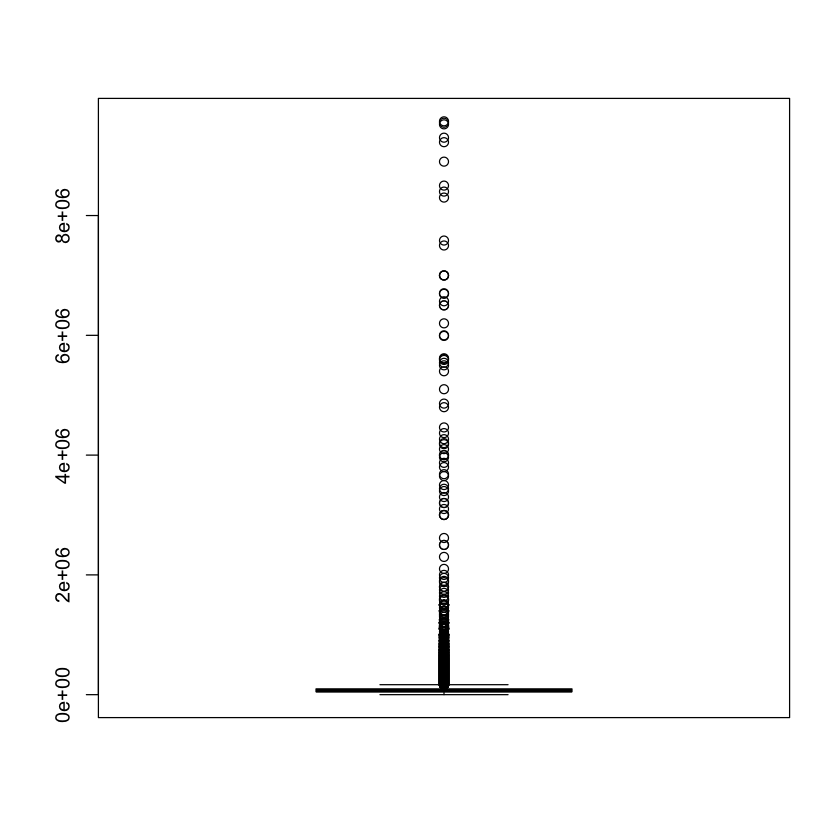

In [9]:
boxplot(x=x[,1])

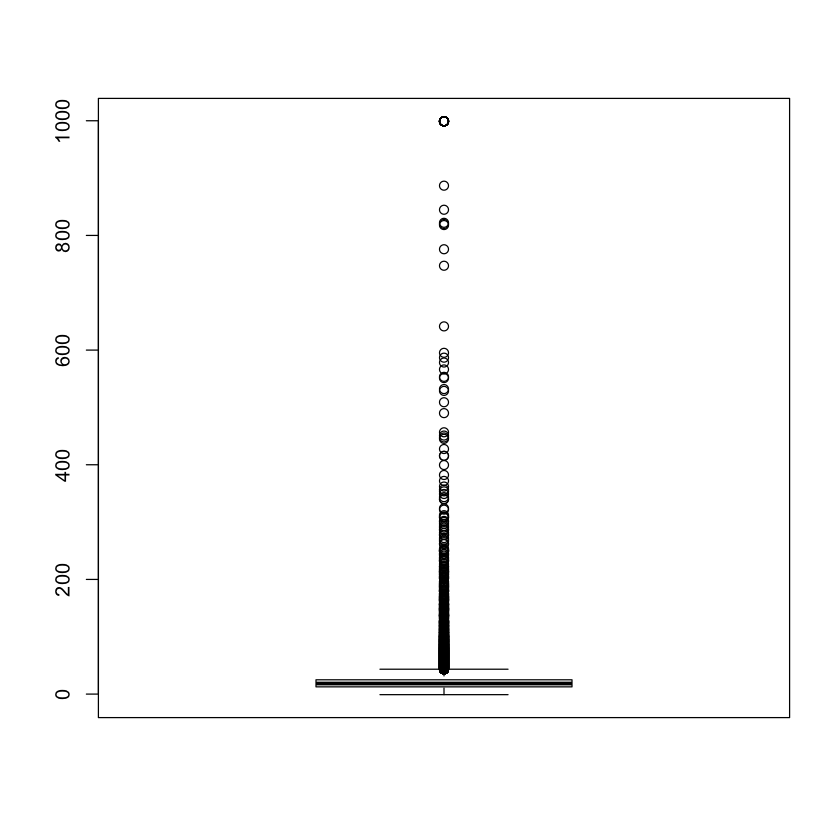

In [10]:
boxplot(x=x[,2])

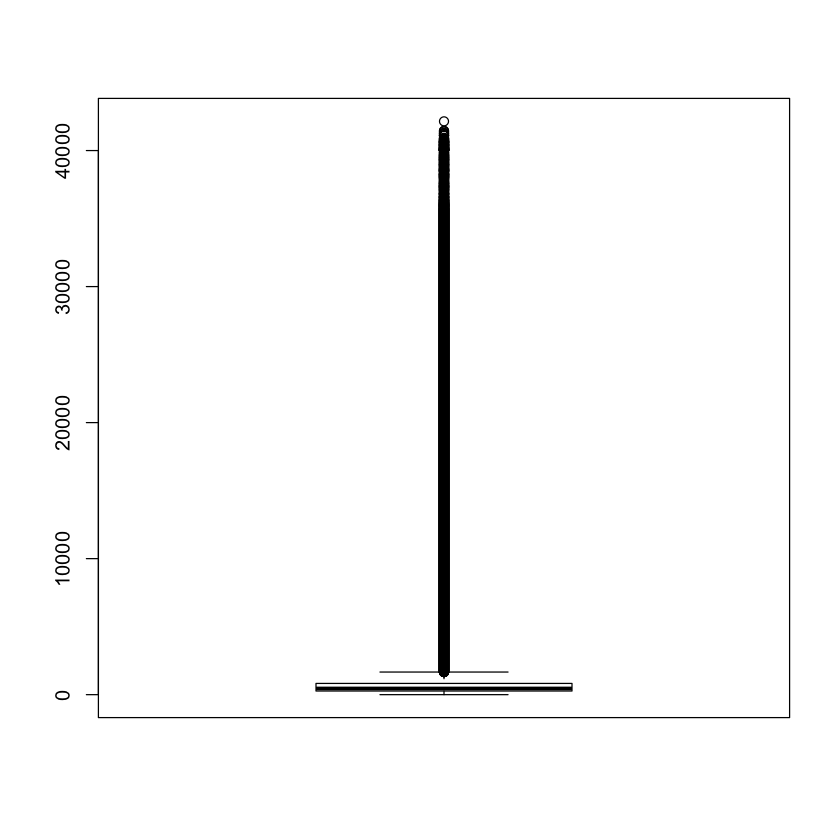

In [11]:
boxplot(x=x[,3])

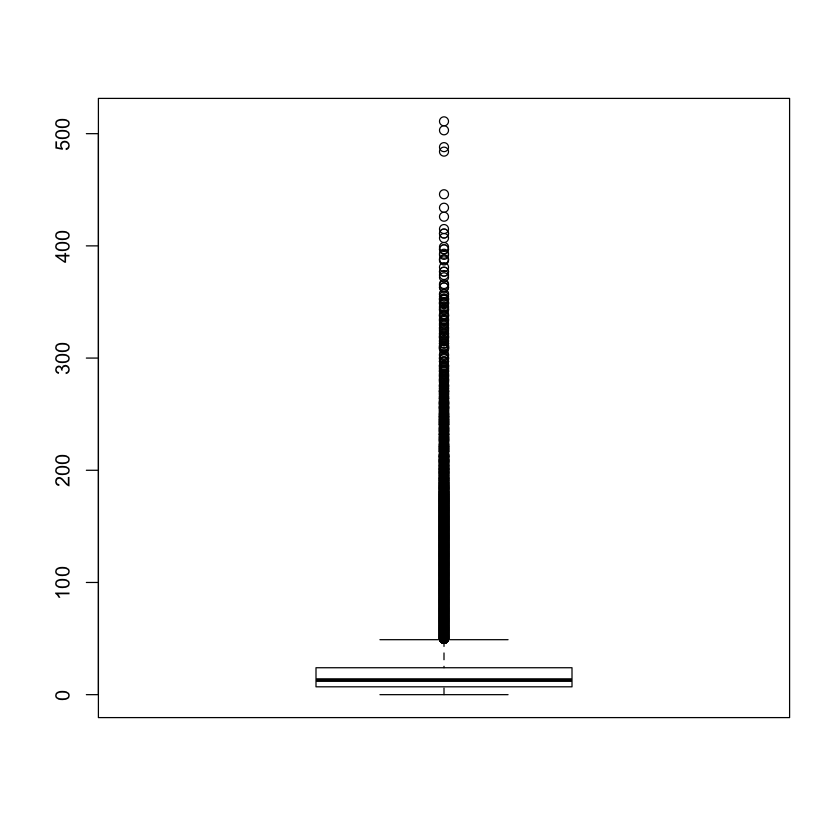

In [12]:
boxplot(x=x[,4])

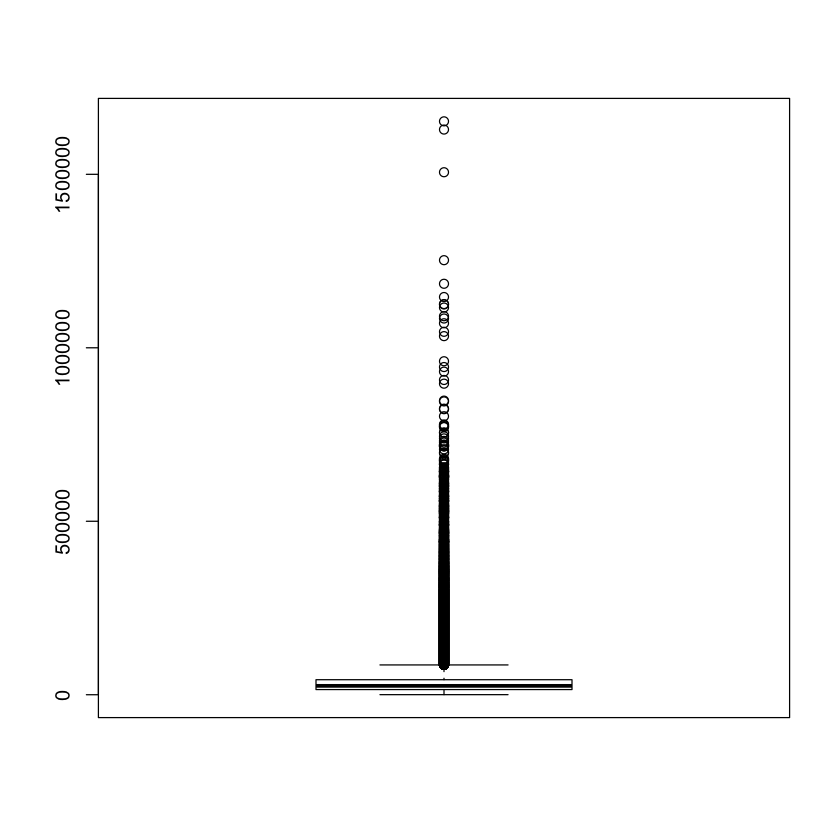

In [13]:
boxplot(x=x[,6])

In [14]:
out_inc <- which(x[,1] > 1e6)
x[out_inc,1] <- NA
out_dti <- which((x[,2]>20)|(x[,2]<0))
x[out_dti,2] <- NA
out_pay <- which(x[,3]>20000)
x[out_pay,3] <- NA
out_mon <- which(x[,4]>24)
x[out_mon,4] <- NA
out_rev <- which(x[,6]>100000)
x[out_rev,6] <- NA

In [15]:
x <- x[complete.cases(x),]

In [16]:
summary(x)

   annual_inc           dti        last_pymnt_amnt   mths_since_rcnt_il
 Min.   :   5000   Min.   : 0.00   Min.   :    0.0   Min.   : 0.00     
 1st Qu.:  55000   1st Qu.:10.68   1st Qu.:  260.6   1st Qu.: 6.00     
 Median :  76000   Median :14.18   Median :  435.1   Median :10.00     
 Mean   :  89735   Mean   :13.59   Mean   : 1792.2   Mean   :11.06     
 3rd Qu.: 108000   3rd Qu.:17.13   3rd Qu.:  814.3   3rd Qu.:16.00     
 Max.   :1000000   Max.   :20.00   Max.   :19999.4   Max.   :24.00     
                                                                       
    all_util      total_rev_hi_lim  inq_last_12m    percent_bc_gt_75
 Min.   :  0.00   Min.   :   200   Min.   : 0.000   Min.   :  0.00  
 1st Qu.: 47.00   1st Qu.: 13000   1st Qu.: 1.000   1st Qu.:  0.00  
 Median : 61.00   Median : 22200   Median : 2.000   Median : 33.30  
 Mean   : 60.16   Mean   : 27615   Mean   : 2.385   Mean   : 37.51  
 3rd Qu.: 74.00   3rd Qu.: 36900   3rd Qu.: 3.000   3rd Qu.: 66.70  
 Max.   :1

# No Cluster

In [17]:
set.seed(1)
train<-sample(1:nrow(x),round(nrow(x)*7/10))
x.train <- x[train,-15]
x.test <- x[-train,-15]

In [18]:
rm(out_inc)
rm(out_dti)
rm(out_pay)
rm(out_mon)
rm(out_rev)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1967126,105.1,6619081,353.5,5263913,281.2
Vcells,10166524,77.6,150451008,1147.9,234813017,1791.5


In [19]:
### Linear Regression ###

In [24]:
x.lm <- lm(int_rate~.,data=x.train)

In [25]:
summary(x.lm)


Call:
lm(formula = int_rate ~ ., data = x.train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.211752 -0.004469 -0.001028  0.003106  0.041916 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3.992e-02  1.311e-04 304.427  < 2e-16 ***
annual_inc           2.258e-09  3.828e-10   5.900 3.65e-09 ***
dti                 -5.876e-06  4.727e-06  -1.243    0.214    
last_pymnt_amnt     -8.850e-08  5.099e-09 -17.356  < 2e-16 ***
mths_since_rcnt_il   4.833e-05  3.259e-06  14.827  < 2e-16 ***
all_util            -1.017e-05  1.338e-06  -7.597 3.05e-14 ***
total_rev_hi_lim     2.924e-08  1.174e-09  24.896  < 2e-16 ***
inq_last_12m        -1.461e-04  7.913e-06 -18.463  < 2e-16 ***
percent_bc_gt_75    -9.558e-06  7.583e-07 -12.605  < 2e-16 ***
term                -7.638e-04  4.884e-05 -15.640  < 2e-16 ***
grade                2.908e-03  6.518e-05  44.612  < 2e-16 ***
sub_grade            7.497e-03  1.325e-05 565.652  < 2e-16 ***
ve

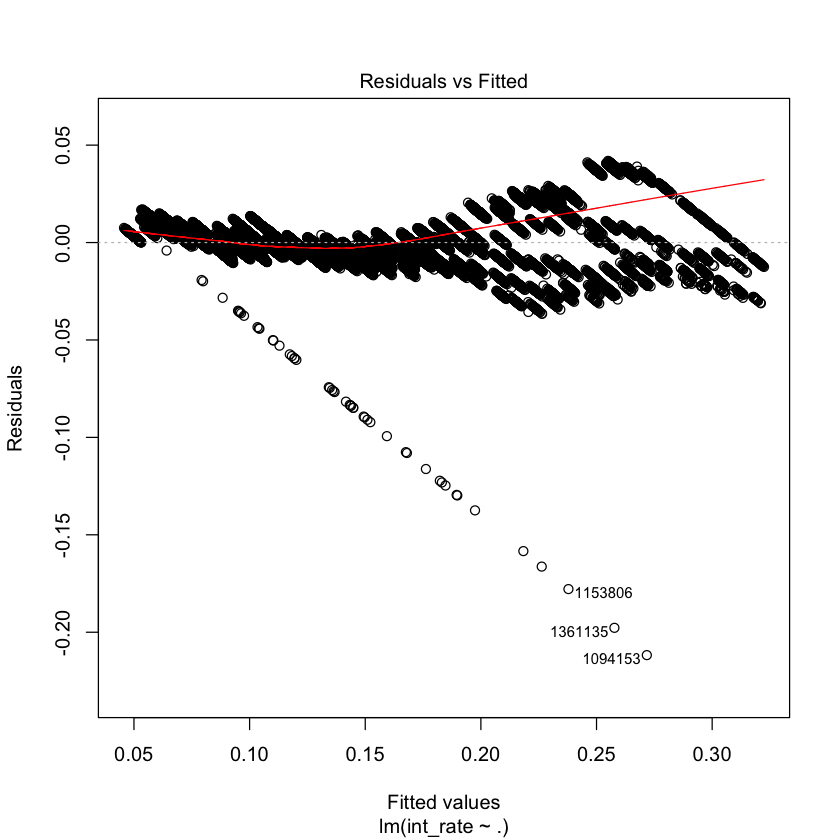

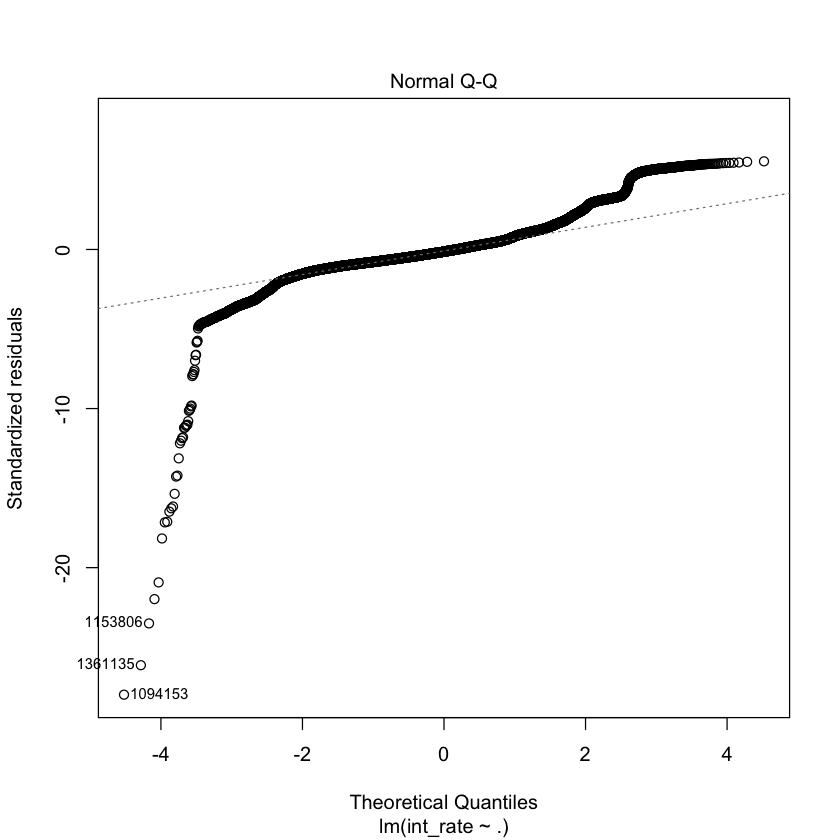

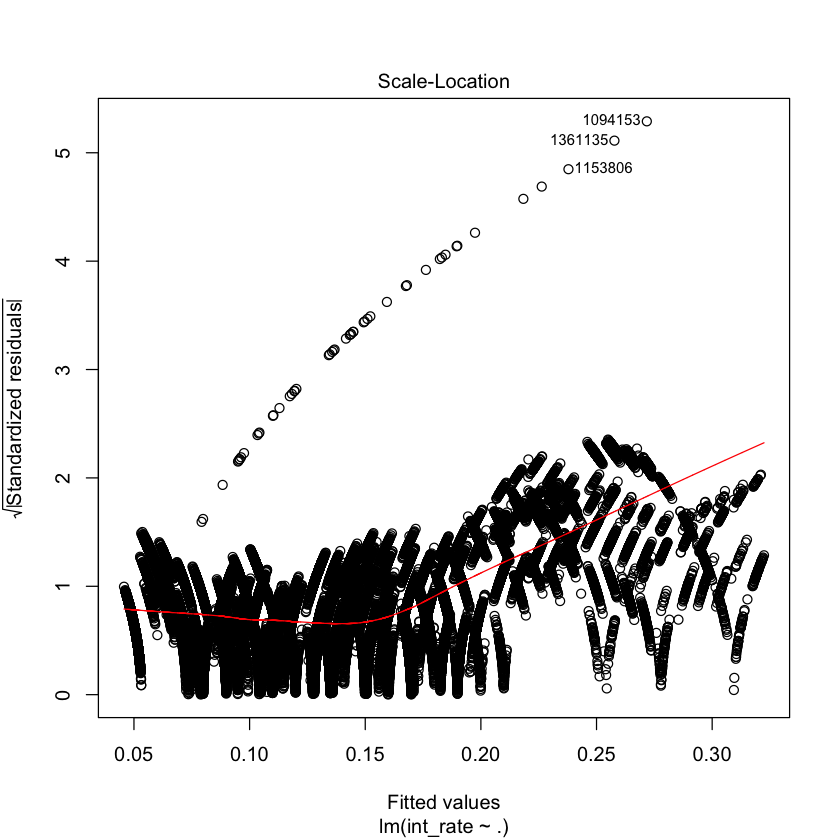

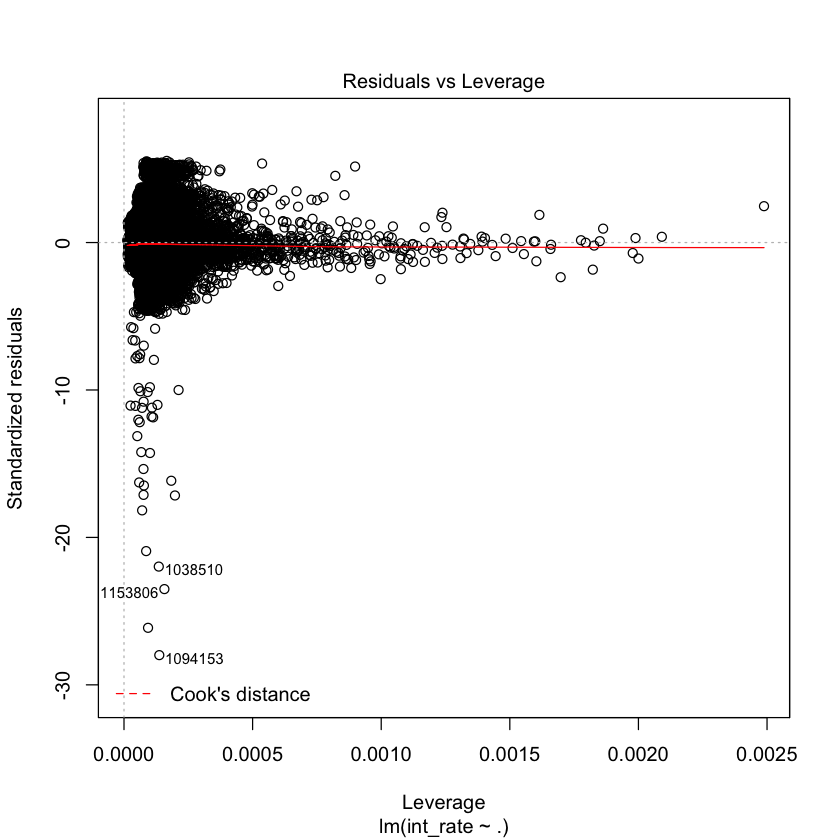

In [26]:
plot(x.lm)

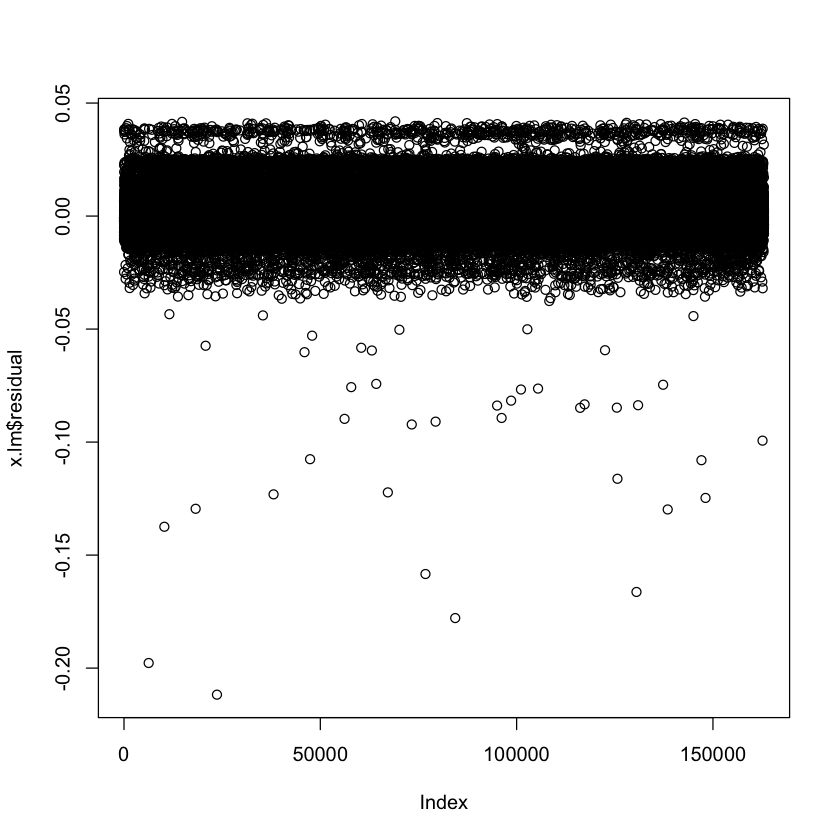

In [27]:
plot(x.lm$residual)

In [28]:
# Prediction
pred.lm <- predict(x.lm,x.test)

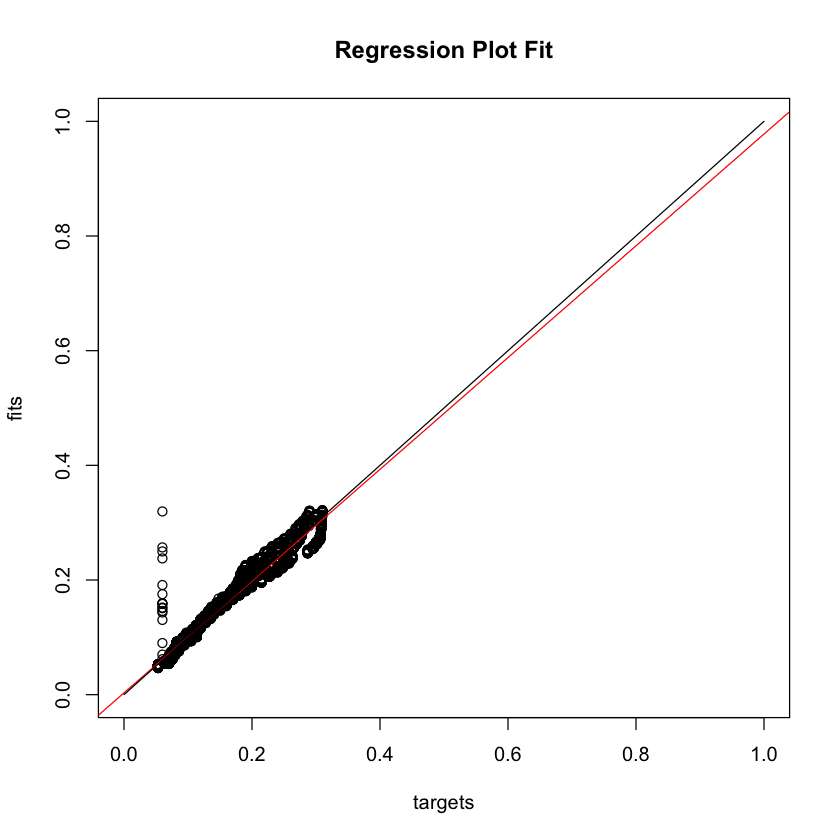

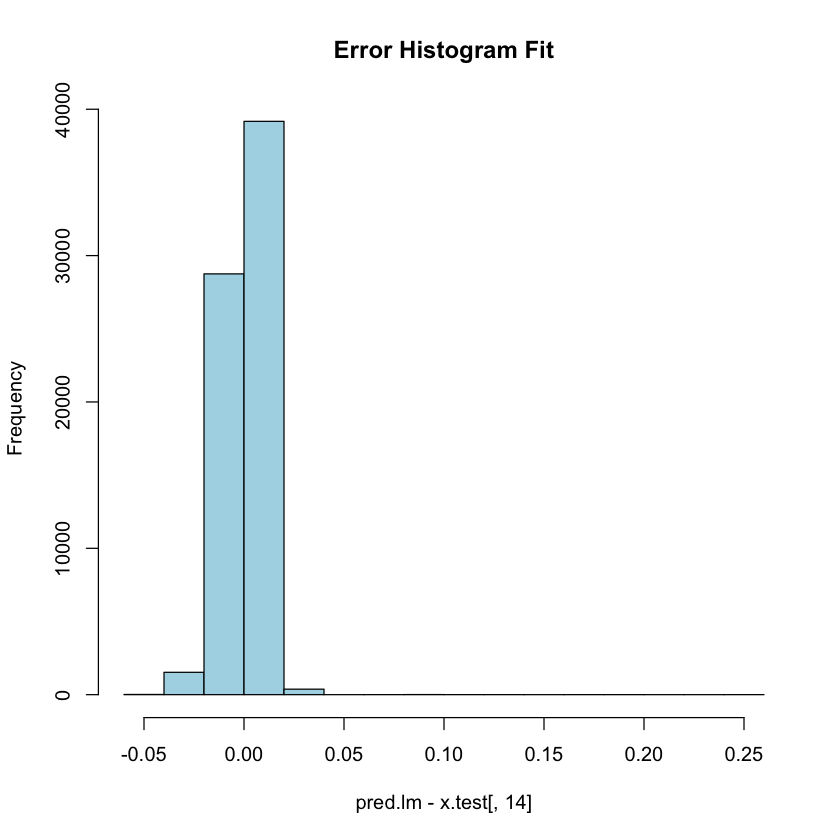

In [29]:
# Plot
plotRegressionError(x.test[,14], pred.lm, main="Regression Plot Fit")
hist(pred.lm-x.test[,14], col="lightblue", main="Error Histogram Fit")

In [30]:
# Metrics
accuracy(pred.lm, x.test[,14])

,ME,RMSE,MAE,MPE,MAPE
Test set,3.559407e-05,0.007629576,0.005297868,0.1912995,4.42812


In [31]:
### Random Forest ###

In [32]:
x.rf <- randomForest(int_rate~., data=x.train, ntree=15, importance=TRUE)

In [33]:
# Feature importance
importance(x.rf,type=1)

,%IncMSE
annual_inc,4.1278828
dti,1.8244965
last_pymnt_amnt,17.3540307
mths_since_rcnt_il,2.4824777
all_util,5.0411310
total_rev_hi_lim,6.6562133
inq_last_12m,-0.4900169
percent_bc_gt_75,5.5285041
term,7.2604081
grade,4.5108896


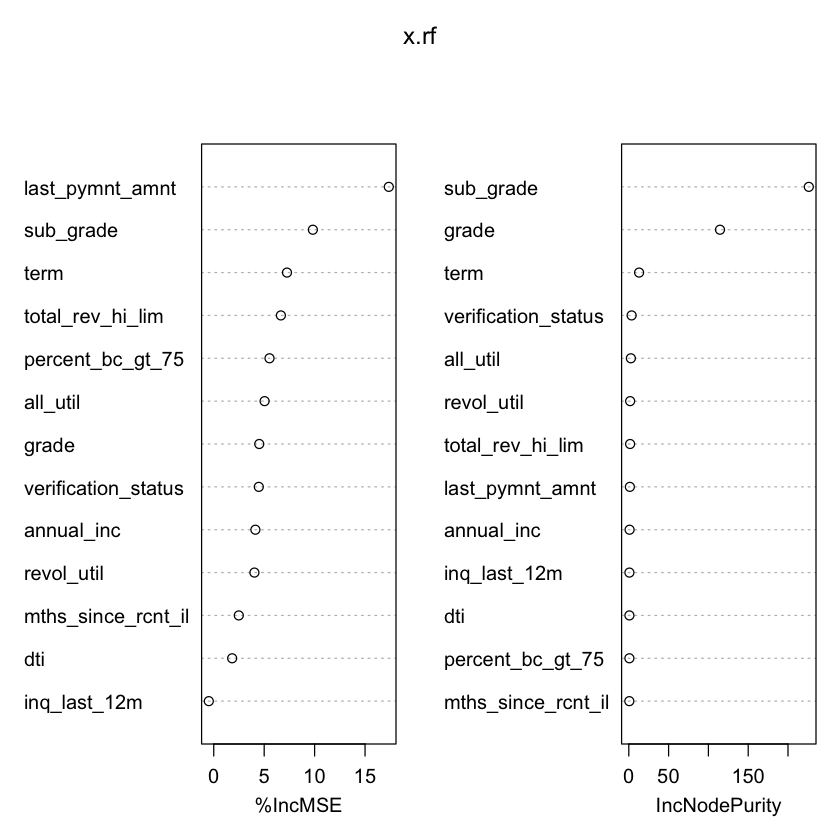

In [34]:
# Visualization
varImpPlot(x.rf)

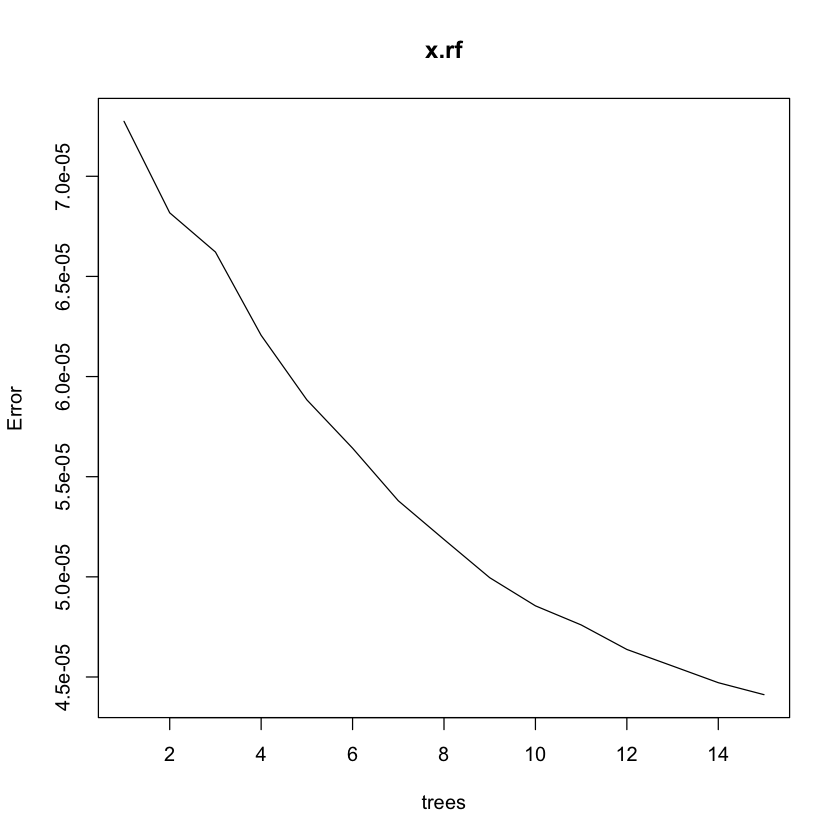

In [35]:
plot(x.rf)

In [36]:
# Prediction
pred.rf <- predict(x.rf,x.test)

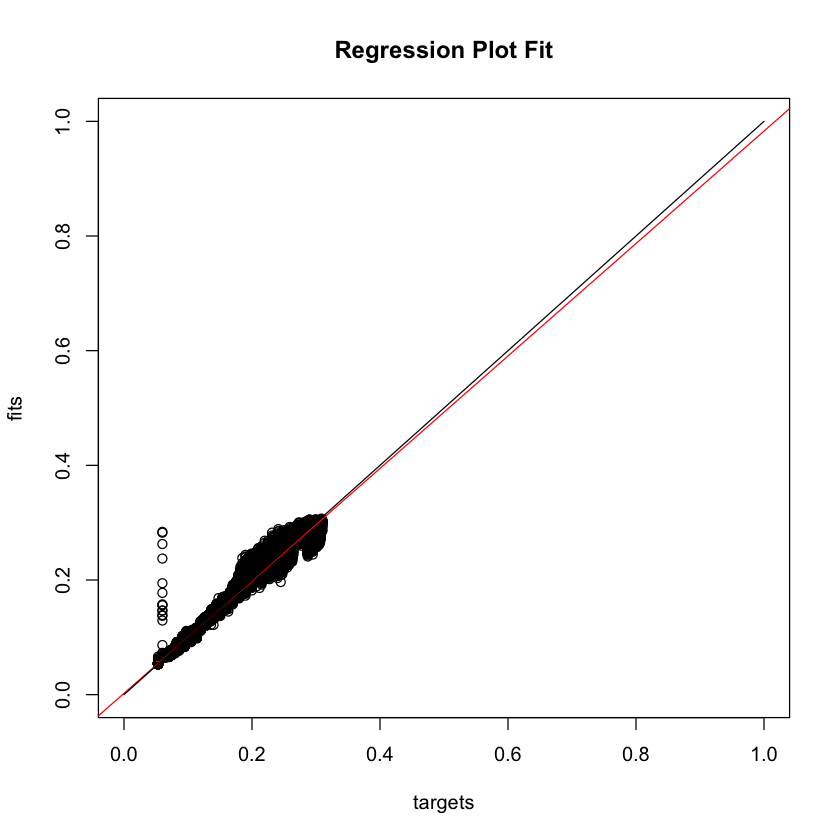

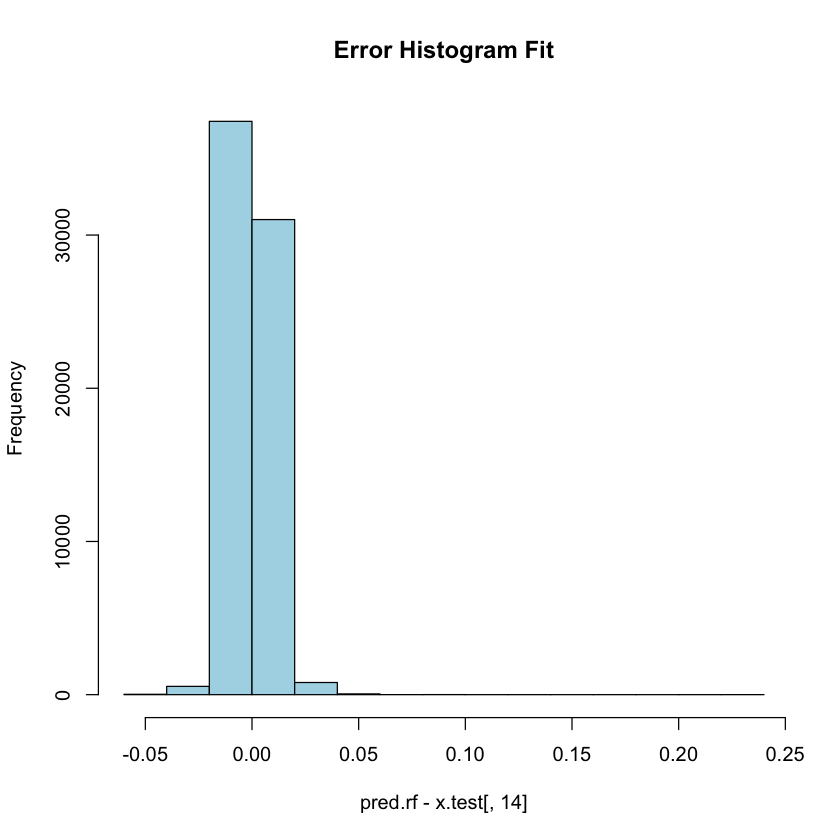

In [37]:
# Plot
plotRegressionError(x.test[,14], pred.rf, main="Regression Plot Fit")
hist(pred.rf-x.test[,14], col="lightblue", main="Error Histogram Fit")

In [38]:
# Metrics
accuracy(pred.rf, x.test[,14])

,ME,RMSE,MAE,MPE,MAPE
Test set,7.780437e-05,0.006278037,0.003631016,-0.1316533,2.697175


In [20]:
### Neural Network ###

In [21]:
f <- as.formula(paste("int_rate ~", paste(names(x.train[,-14]), collapse = " + ")))

In [30]:
x.nn <- mlp(x.train,x.train[,14], size=100, max_iter=200)

In [31]:
pred.nn <- predict(x.nn, x.test)

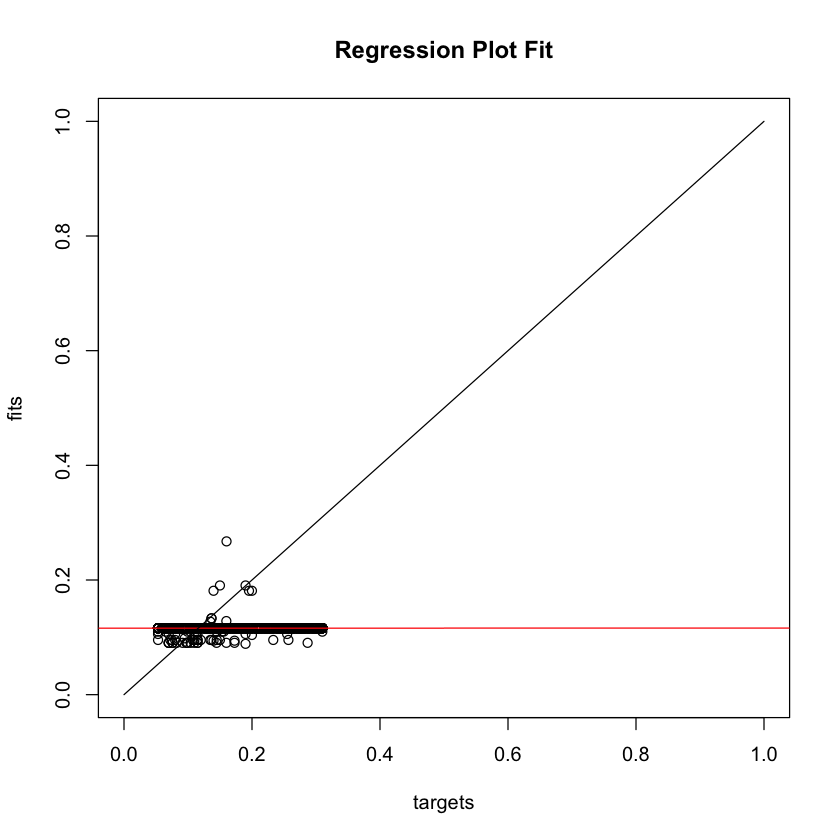

In [32]:
plotRegressionError(x.test[,14], pred.nn, main="Regression Plot Fit")

In [27]:
print(x.nn)

Class: mlp->rsnns
Number of inputs: 14 
Number of outputs: 1 
Maximal iterations: 100 
Initialization function: Randomize_Weights 
Initialization function parameters: -0.3 0.3 
Learning function: Std_Backpropagation 
Learning function parameters: 0.2 0 
Update function:Topological_Order
Update function parameters: 0 
Patterns are shuffled internally: TRUE 
Compute error in every iteration: TRUE 
Architecture Parameters:
$size
[1] 500

All members of model:
 [1] "nInputs"               "maxit"                 "initFunc"             
 [4] "initFuncParams"        "learnFunc"             "learnFuncParams"      
 [7] "updateFunc"            "updateFuncParams"      "shufflePatterns"      
[10] "computeIterativeError" "snnsObject"            "archParams"           
[13] "IterativeFitError"     "fitted.values"         "nOutputs"             


In [33]:
accuracy(pred.nn, x.test[,14])

ERROR: Error in accuracy.default(pred.nn, x.test[, 14]): First argument should be a forecast object or a time series.


In [79]:
# mse.lm <- mse(x.test[,14],pred.lm)
# mae.lm <- mae(x.test[,14],pred.lm)
# mse.rf <- x.rf$mse[10]
# mae.rf <- mae(x.test[,14],pred.rf)

In [34]:
x.knn <- knn.reg(train=x.train[,-14], test=x.test[,-14], y=x.train[,14], k=10)

ERROR: Error in knn.reg(train = x.train[, -14], test = x.test[, -14], y = x.train[, : 没有"knn.reg"这个函数


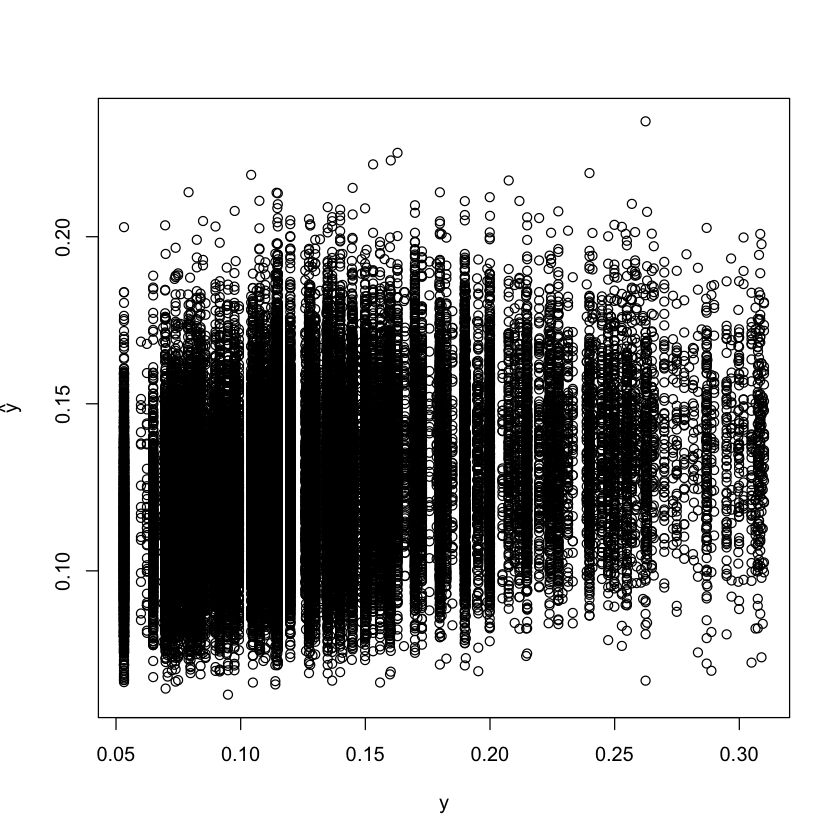

In [81]:
plot(x.test[,14], x.knn$pred, xlab="y", ylab=expression(hat(y)))

In [82]:
accuracy(x.knn$pred, x.test[,14])

,ME,RMSE,MAE,MPE,MAPE
Test set,0.001264921196,0.04618147494,0.03532960877,-11.56316997,31.51046635


In [1]:
??knn.reg